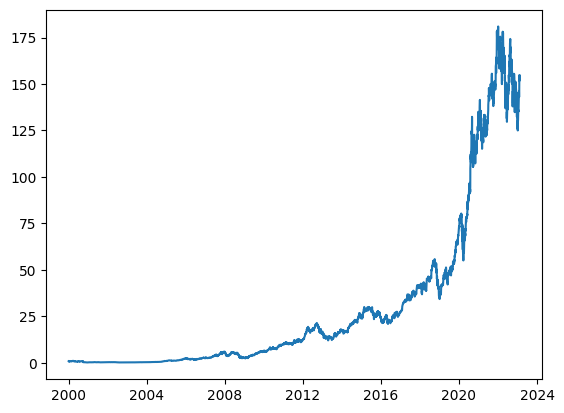

In [93]:
import yfinance
from matplotlib import pyplot as plt
import json
from datetime import *

stock_abbr = 'AAPL'
start, end = '2000-01-01', '2023-12-31'

stock_ticker = yfinance.Ticker(stock_abbr)
stock = stock_ticker.history(start=start, end=end)

plt.plot(stock['Close'])
plt.show()


In [94]:
stock['High_t-1'] = stock.High.shift(1)
stock['Low_t-1'] = stock.Low.shift(1)
stock = stock.tail(-1)

stock['is_gap'] = [stock['High_t-1'][i] < stock['Low'][i] or stock['Low_t-1'][i] > stock['High'][i] for i in range(len(stock))]
stock['is_gap_up'] = [stock['High_t-1'][i] < stock['Low'][i] for i in range(len(stock))]

stock

,Open,High,Low,Close,Volume,Dividends,Stock Splits,High_t-1,Low_t-1,is_gap,is_gap_up
Date,,,,,,,,,,,
2000-01-04,0.823877,0.841953,0.770125,0.780115,512377600,0.0,0.0,0.856223,0.773931,False,False
2000-01-05,0.789628,0.841477,0.783920,0.791530,778321600,0.0,0.0,0.841953,0.770125,False,False
2000-01-06,0.807704,0.814363,0.723033,0.723033,767972800,0.0,0.0,0.841477,0.783920,False,False
2000-01-07,0.734449,0.768698,0.726839,0.757282,460734400,0.0,0.0,0.814363,0.723033,False,False
2000-01-10,0.776309,0.778211,0.721130,0.743963,505064000,0.0,0.0,0.768698,0.726839,False,False
...,...,...,...,...,...,...,...,...,...,...,...
2023-02-01,143.970001,146.610001,141.320007,145.429993,77663600,0.0,0.0,144.339996,142.279999,False,False
2023-02-02,148.899994,151.179993,148.169998,150.820007,118339000,0.0,0.0,146.610001,141.320007,True,True
2023-02-03,148.029999,157.380005,147.830002,154.500000,154279900,0.0,0.0,151.179993,148.169998,False,False


In [95]:
!node get_earnings.js {stock_abbr}

f = open(f'{stock_abbr}.json')
earnings = json.load(f)
print(earnings)
f.close()

!rm {stock_abbr}.json

[['2024-01-31', None], ['2024-01-31', None], ['2023-10-25', None], ['2023-07-26', None], ['2023-04-26', None], ['2023-02-02', 1.88], ['2022-10-27', 1.29], ['2022-07-28', 1.2], ['2022-04-28', 1.52], ['2022-01-27', 2.1], ['2021-10-28', 1.24], ['2021-07-27', 1.3], ['2021-04-28', 1.4], ['2021-01-27', 1.68], ['2020-10-29', 0.73], ['2020-07-30', 0.65], ['2020-04-30', 0.64], ['2020-01-28', 1.25], ['2019-10-30', 0.76], ['2019-07-30', 0.55], ['2019-04-30', 0.62], ['2019-01-29', 1.05], ['2018-11-01', 0.73], ['2018-07-31', 2.34], ['2018-05-01', 2.73], ['2018-02-01', 3.89], ['2017-11-02', 2.07], ['2017-08-01', 1.67], ['2017-05-02', 2.1], ['2017-01-31', 3.36], ['2016-10-25', 1.67], ['2016-07-26', 1.42], ['2016-04-26', 1.9], ['2016-01-26', 3.28], ['2015-10-27', 1.96], ['2015-07-21', 1.85], ['2015-04-27', 2.33], ['2015-01-27', 3.06], ['2014-10-20', 1.42], ['2014-07-22', 1.28], ['2014-04-23', 1.66], ['2014-01-27', 2.07], ['2013-10-28', 1.18], ['2013-07-23', 1.07], ['2013-04-23', 1.44], ['2013-01-23', 

In [96]:
stock['eps'] = None

for i in range(len(earnings) - 1):
    if earnings[i+1][1]:
        stock.loc[earnings[i+1][0] : earnings[i][0], 'eps'] = earnings[i+1][1]
stock

,Open,High,Low,Close,Volume,Dividends,Stock Splits,High_t-1,Low_t-1,is_gap,is_gap_up,eps
Date,,,,,,,,,,,,
2000-01-04,0.823877,0.841953,0.770125,0.780115,512377600,0.0,0.0,0.856223,0.773931,False,False,0.02
2000-01-05,0.789628,0.841477,0.783920,0.791530,778321600,0.0,0.0,0.841953,0.770125,False,False,0.02
2000-01-06,0.807704,0.814363,0.723033,0.723033,767972800,0.0,0.0,0.841477,0.783920,False,False,0.02
2000-01-07,0.734449,0.768698,0.726839,0.757282,460734400,0.0,0.0,0.814363,0.723033,False,False,0.02
2000-01-10,0.776309,0.778211,0.721130,0.743963,505064000,0.0,0.0,0.768698,0.726839,False,False,0.02
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-01,143.970001,146.610001,141.320007,145.429993,77663600,0.0,0.0,144.339996,142.279999,False,False,1.29
2023-02-02,148.899994,151.179993,148.169998,150.820007,118339000,0.0,0.0,146.610001,141.320007,True,True,1.29
2023-02-03,148.029999,157.380005,147.830002,154.500000,154279900,0.0,0.0,151.179993,148.169998,False,False,1.88
